In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import sklearn.feature_extraction
import sklearn.model_selection
import nltk

# Multilayer neural networks

In the previous chapter we saw some history about the perceptron and said that people were thinking that this simple model could do very complex things.
Minsky and Papert changed all that when they published their mathematical proof in 1969 showing that perceptrons were not even able to correctly classify whether two bits were the same or not.
Logistic regression classifiers have this same problem.
Let's see what this means and why.

## The XOR problem

We've seen the NOT gate and the AND gate, but there is another common gate called the exclusive OR gate, or XOR gate.
The behaviour of an XOR gate is to send an 'on' signal when the two signals it receives are different from each other and an 'off' signal otherwise:

| $x_1$ | $x_2$ | $y$ |
|-------|-------|-----|
| 0     | 0     | 0   |
| 0     | 1     | 1   |
| 1     | 0     | 1   |
| 1     | 1     | 0   |

So let's try learning a logistic regression classifier to perform the above training set:

In [2]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

class Logistic(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(torch.zeros((2, 1), dtype=torch.float32))
        self.b = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        return x@self.w + self.b # Just the logits.

model = Logistic()
model.to('cpu')

optimiser = torch.optim.SGD(model.parameters(), lr=10.0)

print('step', 'error')
for step in range(1, 10+1):
    optimiser.zero_grad()
    output = model(train_x)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()
    optimiser.step()

    print(step, error.detach().tolist())
print()

print('x0', 'x1', 'y')
print(0, 0, torch.sigmoid(model(torch.tensor([[0, 0]], dtype=torch.float32))))
print(0, 1, torch.sigmoid(model(torch.tensor([[0, 1]], dtype=torch.float32))))
print(1, 0, torch.sigmoid(model(torch.tensor([[1, 0]], dtype=torch.float32))))
print(1, 1, torch.sigmoid(model(torch.tensor([[1, 1]], dtype=torch.float32))))
print()

print('w:')
print(model.w.data)
print('b:')
print(model.b.data)

step error
1 0.6931471824645996
2 0.6931471824645996
3 0.6931471824645996
4 0.6931471824645996
5 0.6931471824645996
6 0.6931471824645996
7 0.6931471824645996
8 0.6931471824645996
9 0.6931471824645996
10 0.6931471824645996

x0 x1 y
0 0 tensor([[0.5000]], grad_fn=<SigmoidBackward>)
0 1 tensor([[0.5000]], grad_fn=<SigmoidBackward>)
1 0 tensor([[0.5000]], grad_fn=<SigmoidBackward>)
1 1 tensor([[0.5000]], grad_fn=<SigmoidBackward>)

w:
tensor([[0.],
        [0.]])
b:
tensor([0.])


No progress at all happens when starting from all parameters being zero as the parameters remain the same because the gradients remains zero.
In fact there are no parameters you can use that will give you the right output for all inputs.
We can see why this is by plotting the output of the classifier for different parameters.
To avoid having a difficult-to-see 3D graph, we'll instead be using a heat map that uses colour to show where the graph is high (red) and low (blue).

w1: -3.890, w2:  0.108, b:  2.730
w1:  0.500, w2: -0.903, b:  2.511
w1: -3.491, w2: -3.494, b: -2.169
w1:  1.894, w2: -1.715, b:  2.571
w1: -0.356, w2:  3.976, b: -3.565
w1: -2.507, w2:  2.346, b: -1.272
w1: -0.617, w2: -0.544, b:  1.878
w1:  1.441, w2:  2.897, b:  0.061


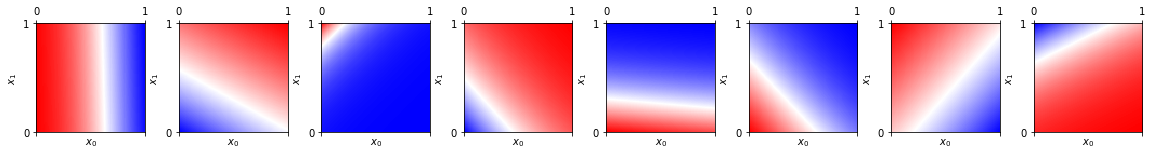

In [3]:
(fig, axs) = plt.subplots(1, 8, figsize=(20, 2))
for i in range(8):
    axs[i].set_xlabel('$x_0$')
    axs[i].set_ylabel('$x_1$')

    w1 = 4*(2*np.random.random() - 1)
    w2 = 4*(2*np.random.random() - 1)
    b = 4*(2*np.random.random() - 1)

    sigmoid = lambda x:1/(1 + np.exp(-x))
    (xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
    ys = sigmoid(w1*xs0 + w2*xs1 + b)
    axs[i].matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

    print('w1: {:6.3f}, w2: {:6.3f}, b: {:6.3f}'.format(w1, w2, b))

To understand these heat maps, the training set is concerned with the four corners of these squares.
Each corner corresponds to the input `[0,0]`, `[0,1]`, `[1,0]`, and `[1,1]`.
In an AND gate, `[0,0]` had to be 0 (blue), `[0,1]` has to be 0 (blue), `[1,0]` had to be 0 (blue), and `[1,1]` had to be 1 (red).
So basically three corners had to be blue whilst the top right corner had to be red.

If you looked at how the heat map changed for different parameters, you'd notice that there's always a straight white line separating the red from the blue.
Note how the only thing that the parameters change is where the line is and how it's rotated (where if it's rotated 180 degrees then the red and blue areas swap sides).
In the case of an AND gate, it is easy to imagine how the line should be positioned to get a red upper right corner with all the other corners being blue.
Unfortunately, in the case of an XOR gate, this isn't possible, because we'd need to position the line in such a way to get the coloured corners below:

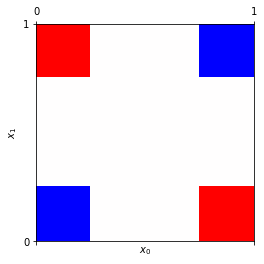

In [4]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')

ys = np.full((100, 100), 0.5)
ys[:25, :25] = 1
ys[:25, -25:] = 0
ys[-25:, -25:] = 1
ys[-25:, :25] = 0
ax.matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

A straight line cannot separate reds and blues as shown above, so, given that different parameters can only work with a straight line, this proves that the logistic regression classifier cannot learn the behaviour of an XOR gate.
We call such problems, that can be solved by a straight line, linearly separable problems.
The XOR problem is a non-linearly separable problem.

## The hidden layer

When Minsky and Papert published this proof about perceptrons, they also gave a solution to it: pass the output of several perceptrons into another perceptron.
a set of perceptrons connected in series could in fact solve the XOR problem, provided you had the right parameters.
The problem was that the learning algorithm of the perceptron could only be used on one perceptron, not two at once.
Gradient descent could be used on two models at once, but the perceptron's sign function does not work with gradient descent because sign has no gradient (it's always 0 as it has no slope steepness to measure).
The logistic regression classifier's sigmoid function, on the other hand, has a gradient and this is when the XOR problem was solved by Rumelhart, Hinton, and Williams in 1986: feeding the output of a logistic regression classifier into another logistic regression classifier.

Let's see the heat map of such a model:

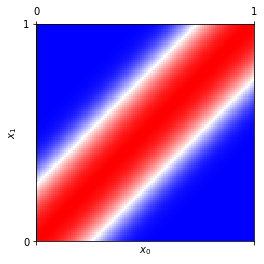

In [5]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')

sigmoid = lambda x:1/(1 + np.exp(-x))
(xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
h1 = sigmoid(-10.0*xs0 + -10.0*xs1 + 15.0)
h2 = sigmoid(-10.0*xs0 + -10.0*xs1 + 5.0)
ys = sigmoid(10.0*h1 + -10.0*h2 + -15.0)
ax.matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

And here we see an example of a non-linear model.
We can now have two slopes in our 3D graph, which allows us to solve the XOR problem.

This is what the graphical diagram of the model looks like:

![](neuron_diagram.png)

Note how we now need to add a third number to the names of the weights and a second number to the name of the biases in order to specify in which layer they belong to.
These layers have names: the first layer of neural units is called the hidden layer, because you don't get to see these outputs, and the second layer is called the output layer.
The output numbers by each neural unit are called activations.
We can also visualise the architecture as a simplified block diagram:

![](block_diagram.png)

It's important to keep in mind that each one of the hidden neural units is still performing a linearly separable task.
What's happening is that we are combining two lines together into a single model.
Let's see the heat map of each hidden neural unit:

Text(0.4, 0.4, 'y')

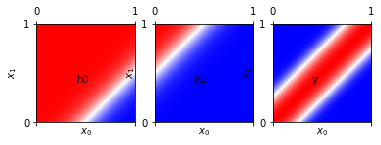

In [6]:
(fig, axs) = plt.subplots(1, 3)
axs[0].set_xlabel('$x_0$')
axs[0].set_ylabel('$x_1$')
axs[1].set_xlabel('$x_0$')
axs[1].set_ylabel('$x_1$')
axs[2].set_xlabel('$x_0$')
axs[2].set_ylabel('$x_1$')

sigmoid = lambda x:1/(1 + np.exp(-x))
(xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
h0 = sigmoid(-10.0*xs0 + -10.0*xs1 + 15.0)
h1 = sigmoid(-10.0*xs0 + -10.0*xs1 + 5.0)
ys = sigmoid(10.0*h0 + -10.0*h1 + -15.0)

axs[0].matshow(h0, cmap='bwr', extent=(0, 1, 0, 1))
axs[0].text(0.4, 0.4, 'h0')
axs[1].matshow(h1, cmap='bwr', extent=(0, 1, 0, 1))
axs[1].text(0.4, 0.4, 'h1')
axs[2].matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))
axs[2].text(0.4, 0.4, 'y')

Let's use this two layer neural network (as it's called) in PyTorch:

In [7]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 2)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((2,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        hidden = torch.sigmoid(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2 # Just the logits.

model = TwoLayer()
model.to('cpu')

optimiser = torch.optim.SGD(model.parameters(), lr=10.0)

print('step', 'error')
for step in range(1, 1000+1):
    optimiser.zero_grad()
    output = model(train_x)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, error.detach().tolist())
print()

print('x0', 'x1', 'y')
print(0, 0, torch.sigmoid(model(torch.tensor([[0, 0]], dtype=torch.float32))).detach().numpy())
print(0, 1, torch.sigmoid(model(torch.tensor([[0, 1]], dtype=torch.float32))).detach().numpy())
print(1, 0, torch.sigmoid(model(torch.tensor([[1, 0]], dtype=torch.float32))).detach().numpy())
print(1, 1, torch.sigmoid(model(torch.tensor([[1, 1]], dtype=torch.float32))).detach().numpy())

step error
100 0.35531601309776306
200 0.3500116765499115
300 0.34868669509887695
400 0.3480917811393738
500 0.34775540232658386
600 0.34753966331481934
700 0.34738969802856445
800 0.3472795784473419
900 0.34719526767730713
1000 0.3471287488937378

x0 x1 y
0 0 [[0.00063024]]
0 1 [[0.49969733]]
1 0 [[0.9994542]]
1 1 [[0.50021815]]


You will note in the above code that the weights were not initialised from zeros like we did with the logistic regression classifier but from random numbers.
In fact starting from zero will not work because all the outputs and gradients will be zero which makes optimisation impossible.
In the case of the logistic regression classifier, initialising the weights randomly would not help, but with a hidden layer it will.
We also want to encourage the different neural units to learn to behave differently from each other.
The standard way to initialise our weights is with random numbers, specifically random numbers generated from a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) (`np.random.normal`).
A normal distribution (more commonly known as a bell curve) is a type of probability distribution that generates numbers such that they have a given mean and standard deviation.
Here we're generating numbers that have a mean of 0 and standard deviation of 1, so the numbers will be around zero (positive and negative numbers).
In general, the rule of thumb is to make the weights have a mean of zero and a small standard deviation whilst the biases should be initialised from zeros without any random numbers.

Adding more hidden layer units allows us to create more complex graph shapes when plotting the model's output.
Below is a plot of a three unit hidden layer network:

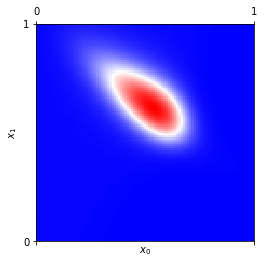

In [8]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')

sigmoid = lambda x:1/(1 + np.exp(-x))
(xs1, xs0) = np.mgrid[0:1.01:0.01, 0:1.01:0.01]
h0 = sigmoid(10.0*xs0 + 5.0*xs1 + -10.0)
h1 = sigmoid(-10.0*xs0 + 10.0*xs1 + 0.0)
h2 = sigmoid(5.0*xs0 + -10.0*xs1 + 0.0)
ys = sigmoid(-10.0*h0 + -10.0*h1 + -10.0*h2 + 5.0)

ax.matshow(ys, cmap='bwr', extent=(0, 1, 0, 1))

A larger hidden layer will allow for more complexity, but is there enough complexity?
Will adding a second hidden layer allow the network to learn even more complex behaviour?

The answer is no, a large enough single hidden layer can learn to perform any task, provided that you find the right parameters.
In fact there is a [mathematical proof](https://www.sciencedirect.com/science/article/abs/pii/0893608089900208) that shows that single hidden layer neural networks (with enough neural units) are universal approximators, that is, can have any finite region of their graph be made into approximately any shape.
'Approximately any shape' means that you can get as close as you want but, in many cases, never reach a perfect match.
Note that polynomials are also univeral approximators, given enough terms in the polynomial.

On the other hand, there is also [another mathematical proof](http://proceedings.mlr.press/v49/eldan16.html) that shows that, whilst having two hidden layers does not add more expressiveness than that of a single hidden layer network, it does enable the network to require less neural units in total.
So adding more hidden layers results in more efficient networks that can be more complex with less parameters, which is always good.

## Training better

Whilst it is definitely possible to optimise our two layer model to learn many complex behaviour, it is also more difficult to do so than the normal logistic regression classifier.
This is because the error surface is no longer convex.

We can't visualise all 9 parameters as that would require us to plot a 10 dimensional graph.
What we'll do instead is show a 3D slice through the 10 dimensional graph by only varying two of the ten parameters whilst keeping all the other parameters fixed to a random value.
We'll be plotting the error on the XOR training set.

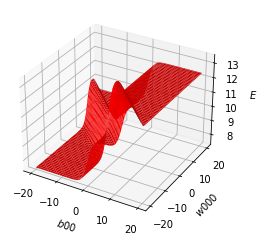

In [9]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$b00$')
ax.set_ylabel('$w000$')
ax.set_zlabel('$E$')

w001 = 20*(2*np.random.random() - 1)
w010 = 20*(2*np.random.random() - 1)
w011 = 20*(2*np.random.random() - 1)
b01  = 20*(2*np.random.random() - 1)
w100 = 20*(2*np.random.random() - 1)
w110 = 20*(2*np.random.random() - 1)
b10  = 20*(2*np.random.random() - 1)

sig = lambda x:1/(1 + np.exp(-x))
nn = lambda x0, x1, w000, w001, w010, w011, b00, b01, w100, w110, b10: \
    sig(w100*sig(x0*w000 + x1*w010 + b00) + w110*sig(x0*w001 + x1*w011 + b01) + b10)
f = lambda w000,b00:0.25*(
    -np.log(1 - nn(0, 0, w000, w001, w010, w011, b00, b01, w100, w110, b10)) # target 0
    + -np.log(nn(0, 1, w000, w001, w010, w011, b00, b01, w100, w110, b10)) # target 1
    + -np.log(nn(1, 0, w000, w001, w010, w011, b00, b01, w100, w110, b10)) # target 1
    + -np.log(1 - nn(1, 1, w000, w001, w010, w011, b00, b01, w100, w110, b10)) # target 0
)
(ws, bs) = np.mgrid[-20:20.1:0.1, -20:20.1:0.1]
es = f(ws, bs)
ax.plot_surface(bs, ws, es, color='red', linewidth=0, antialiased=True)

Imagine how complex the entire 10-dimensional graph is.
Due to this complexity, several techniques were developed in order to help with training.

### Minibatches

Since the error surface is no longer convex, we now run the risk of getting stuck in a local minimum, which is a point in the error surface where any small change in parameters will result in a larger error, so training cannot continue, but which is not the smallest error in the entire error surface.
Below is an example:

Text(3.5, 1.0, 'local and global minimum')

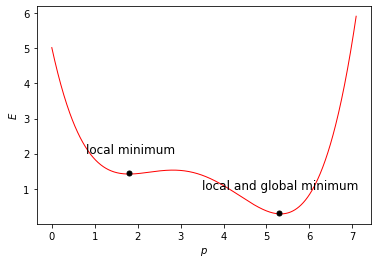

In [10]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$p$')
ax.set_ylabel('$E$')

f = lambda p:0.052*p**4 - 0.69*p**3 + 3.09*p**2 - 5.63*p + 5.02
ps = np.mgrid[0:7.1:0.01]
es = f(ps)
ax.plot(ps, es, color='red', marker='', linestyle='-', linewidth=1)

ax.plot([1.8, 5.3], [1.45, 0.3], color='black', marker='o', markersize=5, linestyle='')
ax.text(0.8, 2.0, 'local minimum', fontdict={'fontsize': 12})
ax.text(3.5, 1.0, 'local and global minimum', fontdict={'fontsize': 12})

Here we see an error surface with a single parameter ($p$) which has two local minima, only one of which is a global minimum.
If gradient descent gets you in the first local minimum, it will not be able to escape it (unless the learning rate is too large, in which case you'll have bigger problems).

To make gradient descent be able to avoid this problem, we do not calculate the error on the entire training set.
Instead we take a random sample of training set rows and calculate the error on that.
This sample is called a minibatch.
After completing an update step on this minibatch, another different minibatch is loaded and another update step is performed based on the new minibatch, and so on.

The first advantage of using minibatches instead of the entire training set at once is that you do not need to pass in the entire training set to the neural network, which would take a lot of memory for large data sets (including GPU memory, which is limited).
The second advantage is that the error surface is changing with each update, meaning that getting stuck in a local minimum will probably only last for one update step.
After changing the minibatch you will have a new error surface which will have differently positioned local minima, hence you would be able to continue progressing.

Of course this makes training less stable and the error will tend to fluctuate during training, which is a disadvantage.
To make the process more stable, we use a smaller learning rate in order to avoid going too far off in random directions.
In general, the process tends to improve training and is the standard way to train neural networks.
The optimisation algorithm of using gradient descent with minibatches is called stochastic gradient descent (SGD) because of the randomness introduced from the random training samples.

The full SGD algorithm works as follows.
Randomly shuffle the order of the rows in the training set and take the first $m$ items, where $m$ is a minibatch size that you choose.
This will be the first minibatch.
Now perform an update step on this minibatch and then take the next $m$ items from the training set.
Repeat this process until all the items in the training set have been visited.
Going through the entire training set is called an epoch.
Having finished an epoch, reshuffle the training set and repeat for a number of epochs.

This guarantees that all the items in the training set are visited equally.
Below is how you'd do this in Python:

Start by having your training set defined as a NumPy array instead of a PyTorch tensor.
The minibatch will be placed in a PyTorch tensor, the whole training set does not need to be.

In [11]:
train_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], np.float32)
train_y = np.array([[0], [1], [1], [0]], np.float32)

Since the training set consists of several arrays (`train_x` and `train_y`), we need to shuffle each array in the same way, otherwise they won't match any more.
The neatest way to do this is to take advantage of NumPy's array indexing features which allow you to pass a list of indexes to an array:

    x = np.array([10, 20, 30, 40, 50])
    y = x[[0,2,3]]
    # y contains [10, 30, 40]

What we'll do is shuffle an array of indexes and then use the randomised indexes to load minibatches.

In [12]:
indexes = np.arange(len(train_x))
np.random.shuffle(indexes)
print(indexes)

[1 2 0 3]


Now use the shuffled indexes to extract minibatches (for a given minibatch size):

In [13]:
minibatch_size = 2
num_minibatches = int(np.ceil(len(train_x)/minibatch_size))
for i in range(num_minibatches):
    print('minibatch:', i)
    minibatch_indexes = indexes[i*minibatch_size:(i+1)*minibatch_size]
    print('minibatch_indexes:', minibatch_indexes.tolist())
    print('train_x:', train_x[minibatch_indexes].tolist())
    print('train_y:', train_y[minibatch_indexes].tolist())
    print()

minibatch: 0
minibatch_indexes: [1, 2]
train_x: [[0.0, 1.0], [1.0, 0.0]]
train_y: [[1.0], [1.0]]

minibatch: 1
minibatch_indexes: [0, 3]
train_x: [[0.0, 0.0], [1.0, 1.0]]
train_y: [[0.0], [0.0]]



You can now apply a step of gradient descent on each minibatch extracted from the training set.

Here is the full SGD training process in PyTorch:

In [14]:
train_x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], np.float32)
train_y = np.array([[0], [1], [1], [0]], np.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 2)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((2,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        hidden = torch.sigmoid(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2

model = TwoLayer()
model.to('cpu')

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('epoch', 'error')
for epoch in range(1, 1000+1):
    indexes = np.arange(len(train_x))
    np.random.shuffle(indexes)

    minibatch_size = 2
    num_minibatches = int(np.ceil(len(train_x)/minibatch_size))
    for i in range(num_minibatches):
        minibatch_indexes = indexes[i*minibatch_size:(i+1)*minibatch_size]
        minibatch_x = torch.tensor(train_x[minibatch_indexes], dtype=torch.float32, device='cpu')
        minibatch_y = torch.tensor(train_y[minibatch_indexes], dtype=torch.float32, device='cpu')

        optimiser.zero_grad()
        output = model(minibatch_x)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, minibatch_y)
        error.backward()
        optimiser.step()

    if epoch%100 == 0:
        print(epoch, error.detach().tolist())
print()

print('x0', 'x1', 'y')
print(0, 0, torch.sigmoid(model(torch.tensor([[0, 0]], dtype=torch.float32))))
print(0, 1, torch.sigmoid(model(torch.tensor([[0, 1]], dtype=torch.float32))))
print(1, 0, torch.sigmoid(model(torch.tensor([[1, 0]], dtype=torch.float32))))
print(1, 1, torch.sigmoid(model(torch.tensor([[1, 1]], dtype=torch.float32))))

epoch error
100 0.6974338889122009
200 0.060346219688653946
300 0.03017815202474594
400 0.02041076123714447
500 0.012736033648252487
600 0.009971623308956623
700 0.008884832262992859
800 0.0080269705504179
900 0.006529876030981541
1000 0.005015470553189516

x0 x1 y
0 0 tensor([[0.0065]], grad_fn=<SigmoidBackward>)
0 1 tensor([[0.9950]], grad_fn=<SigmoidBackward>)
1 0 tensor([[0.9950]], grad_fn=<SigmoidBackward>)
1 1 tensor([[0.0056]], grad_fn=<SigmoidBackward>)


### Momentum

Sometimes the error surface is shaped like a valley with a very gentle slope as shown below:

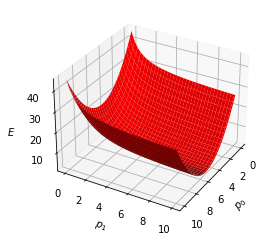

In [15]:
(fig, ax) = plt.subplots(1, 1, subplot_kw={'projection': '3d'})
ax.set_xlabel('$p_0$')
ax.set_ylabel('$p_1$')
ax.set_zlabel('$E$')

f = lambda p0,p1:(p0-5)**2 + 20/(p1+1.0)
(p0s, p1s) = np.mgrid[0:10.1:0.1, 0:10.1:0.1]
es = f(p0s, p1s)
ax.plot_surface(p0s, p1s, es, color='red', linewidth=0, antialiased=True)
ax.view_init(30, 30)

In this case you'll end up moving very slowly down the gentle slope whilst jumping back and forth along the walls of the valley.
This is a problem but it has a simple solution: momentum.

In physics, momentum is when speed builds up as you move, making it harder to slow down.
In gradient descent we can do something like that by adding a fraction of the previous update to the new update.
Consider the gradient descent update equation:

$$p_{t+1} = p_t - \alpha \nabla_{p_t}$$

where $p_t$ is the parameter to update, $p_{t+1}$ is the updated parameter, $\alpha$ is the learning rate, and $\nabla_{p_t}$ is the gradient with respect to the parameter.
$\nabla_{p_t}$ is the velocity with which we are moving along the parameter's direction.
We shall now modify it so that a fraction of the previous velocity is included in the new velocity:

$$v_{t+1} = \mu v_t + \nabla_{p_t}$$
$$p_{t+1} = p_t - \alpha v_{t+1}$$

where $\mu$ is the fraction of the previous velocity to apply to the update step, called the momentum.
The bigger $\mu$ is, the less gradient descent will be affected by the current gradient and the more it will be affected by the total of the previous gradients during training.
In the case of the above valley situation, this will make the extent of jumping back and forth across the walls of the valley become smaller and smaller as the gradient in that direction will constantly oscillate from positive to negative, making the total of the gradients in that direction approach zero.
It will also accelerate the movement along the gentle slope as the total gradient is constantly increasing.

Note that normal gradient descent can be treated as momentum with $\mu = 0$.

To use it in PyTorch is very easy:

    optimiser = torch.optim.SGD(model.parameters(), lr=1.0, momentum=0.9)

In [16]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 2)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((2,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        hidden = torch.sigmoid(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2

model = TwoLayer()
model.to('cpu')

optimiser = torch.optim.SGD(model.parameters(), lr=1.0, momentum=0.9)

print('step', 'error')
for step in range(1, 1000+1):
    optimiser.zero_grad()
    output = model(train_x)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, error.detach().tolist())
print()

print('x0', 'x1', 'y')
print(0, 0, torch.sigmoid(model(torch.tensor([[0, 0]], dtype=torch.float32))).detach().tolist())
print(0, 1, torch.sigmoid(model(torch.tensor([[0, 1]], dtype=torch.float32))).detach().tolist())
print(1, 0, torch.sigmoid(model(torch.tensor([[1, 0]], dtype=torch.float32))).detach().tolist())
print(1, 1, torch.sigmoid(model(torch.tensor([[1, 1]], dtype=torch.float32))).detach().tolist())

step error
100 0.01171719841659069
200 0.004896038211882114
300 0.0031819541472941637
400 0.002360434038564563
500 0.0018768522422760725
600 0.0015579694882035255
700 0.0013317809207364917
800 0.0011629009386524558
900 0.0010320686269551516
1000 0.0009276579366996884

x0 x1 y
0 0 [[0.0008831194718368351]]
0 1 [[0.998776376247406]]
1 0 [[0.999175488948822]]
1 1 [[0.0007738250424154103]]


There are also other more advanced gradient descent optimisers, such as Adam, which adapts the learning rate during training based on the previous gradients measured.
It also adapts a different learning rate for each parameter rather than use one learning rate for all parameters, which is useful.
This in turn means that the learning rate does not usually need to be set as the default initial learning rate usually works well.

To use the Adam optimiser in PyTorch:

    optimiser = torch.optim.Adam(model.parameters())

### Vanishing gradients

Adding more layers often results in a problem called the vanishing gradient problem, which is where the layers closer to the input end up having a negligible gradient.
Among other reasons, this is because the gradient at a particular layer involves multiplying the activations of all the layers in front of it.
Since sigmoid's output is always a fraction between 0 and 1, multiplying a sequence of such fractions together will quickly result in very small values, making the gradient be close to zero.

Here we can see a plot of how the average magnitude of the gradients of the weights of two layers vary in a scatter plot:

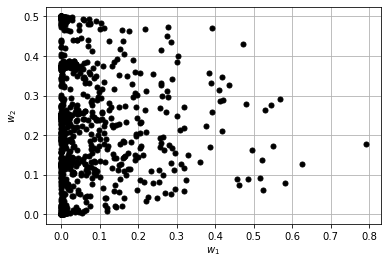

In [17]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(20*(2*np.random.random((2, 2)) - 1), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.tensor(20*(2*np.random.random((2,)) - 1), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(20*(2*np.random.random((2, 1)) - 1), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.tensor(20*(2*np.random.random((1,)) - 1), dtype=torch.float32))

    def forward(self, x):
        hidden = torch.sigmoid(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2

w1_grads = []
w2_grads = []
for _ in range(1000):
    model = TwoLayer()
    model.to('cpu')

    output = model(train_x)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()

    w1_grads.append(model.w1.grad.abs().mean())
    w2_grads.append(model.w2.grad.abs().mean())

    model.w1.grad.zero_()
    model.w2.grad.zero_()

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.plot(w1_grads, w2_grads, color='black', marker='o', markersize=5, linestyle='')
ax.grid()

Note how the majority of the large gradients are closer to $w_2$, the weights of the output layer.
The more layers you add, the smaller the gradients of the early layers get, which makes training them by gradient descent difficult.

To avoid this, we use a different function from sigmoid in the hidden layers which can have larger values.
A popular activation function, as they're called, is the rectified linear unit (ReLU), which is defined as

$$y = \max(0, x)$$

that is, leave the input as-is when it is positive and replace it with zero when it is negative.

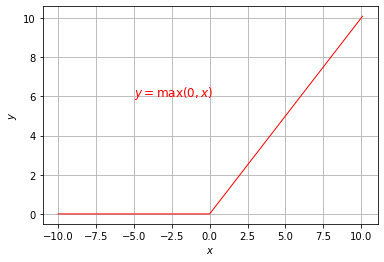

In [18]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

xs = np.mgrid[-10:10.1:0.01]
ys = np.maximum(0, xs)
ax.plot(xs, ys, color='red', marker='', linestyle='-', linewidth=1)
ax.text(-5, 6, '$y = \max(0, x)$', color='red', fontdict={'fontsize': 12})
ax.grid()

Since large values are more likely with ReLU, there tends to be less vanishing gradients.

Let's see how the gradients of the two layers vary now:

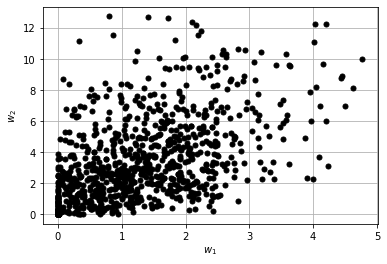

In [19]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(20*(2*np.random.random((2, 2)) - 1), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.tensor(20*(2*np.random.random((2,)) - 1), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(20*(2*np.random.random((2, 1)) - 1), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.tensor(20*(2*np.random.random((1,)) - 1), dtype=torch.float32))

    def forward(self, x):
        hidden = torch.nn.functional.relu(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2

w1_grads = []
w2_grads = []
for _ in range(1000):
    model = TwoLayer()
    model.to('cpu')

    output = model(train_x)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()

    w1_grads.append(model.w1.grad.abs().mean())
    w2_grads.append(model.w2.grad.abs().mean())

    model.w1.grad.zero_()
    model.w2.grad.zero_()

(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.plot(w1_grads, w2_grads, color='black', marker='o', markersize=5, linestyle='')
ax.grid()

The gradients are still skewed in magnitude but look more distributed than with sigmoid.

However, ReLU has a problem known as the dead ReLU problem, which is when a lot of your neural units end up always outputting zero, regardless of what the neural network's input is.
To prevent this, the Leaky ReLU is sometimes used instead which replaces the zero with a fraction of the input such as

$$y = \max\left(\frac{1}{10}x, x\right)$$

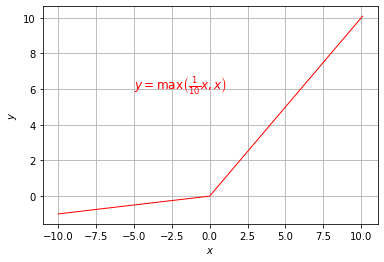

In [20]:
(fig, ax) = plt.subplots(1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

xs = np.mgrid[-10:10.1:0.01]
ys = np.maximum(0.1*xs, xs)
ax.plot(xs, ys, color='red', marker='', linestyle='-', linewidth=1)
ax.text(-5, 6, '$y = \max\\left(\\frac{1}{10}x, x\\right)$', color='red', fontdict={'fontsize': 12})
ax.grid()

which in PyTorch is defined as

    torch.nn.functional.leaky_relu(x, 0.1)

In [21]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 2)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((2,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        hidden = torch.nn.functional.leaky_relu(x@self.w1 + self.b1, 0.1)
        return hidden@self.w2 + self.b2

model = TwoLayer()
model.to('cpu')

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('step', 'error')
for step in range(1, 1000+1):
    optimiser.zero_grad()
    output = model(train_x)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, error.detach().tolist())
print()

print('x0', 'x1', 'y')
print(0, 0, torch.sigmoid(model(torch.tensor([[0, 0]], dtype=torch.float32))).detach().tolist())
print(0, 1, torch.sigmoid(model(torch.tensor([[0, 1]], dtype=torch.float32))).detach().tolist())
print(1, 0, torch.sigmoid(model(torch.tensor([[1, 0]], dtype=torch.float32))).detach().tolist())
print(1, 1, torch.sigmoid(model(torch.tensor([[1, 1]], dtype=torch.float32))).detach().tolist())

step error
100 0.45098739862442017
200 0.4509734809398651
300 0.4509735107421875
400 0.4509734511375427
500 0.4509734511375427
600 0.4509734511375427
700 0.4509734511375427
800 0.4509734511375427
900 0.4509734511375427
1000 0.4509734511375427

x0 x1 y
0 0 [[0.05697077885270119]]
0 1 [[0.9430292248725891]]
1 0 [[0.4302929639816284]]
1 1 [[0.5697069764137268]]


## Avoiding overfitting

When a model makes very good predictions on the training set but bad predictions on other data, we say that the model has overfitted to the training set, which is bad.
Ideally, the model learns something that generalises to other data.

In the previous topic we saw how L2-weight decay can be used to reduce overfitting by avoiding the use of large weights for a particular input.
That input might be very useful in the training set but chances are that it was just a coincidence and will not be there outside of the training set.
So L2-weight decay will force the neural network to keep the weights somewhat balanced across inputs so that all input are considered and not just the ones that work well in the training set.
This is still possible to do in a two layer neural network, but there are other things we can do as well.

### Early stopping

The easiest way to avoid overfitting is by using early stopping.
Keep a small part of the training set separate, called a validation set, and don't use it for training.
Instead, use it to measure performance after every epoch (such as measuring model's the accuracy).
This will tell you whether the model is just learning the training set by heart or if it's generalising to data outside of the training set.
By monitoring the performance on the validation set, you can stop training as soon as the performance starts going down, hence why it's called early stopping.

Rather than stopping as soon as the performance goes down, a number of 'bad' epochs are allowed in order to give the model a chance to improve again.
The model parameters are then saved every time the validation set performance improves so that the best performing parameters are returned at the end.
The maximum number of less-than-best epochs to allow is called the patience.

Performance tip: avoid having PyTorch preparing to compute gradients when not necessary (such as when using the model outside of training) by putting your module calls in a `torch.no_grad()` context:

    with torch.no_grad():
        print(0, 0, torch.sigmoid(model(torch.tensor([[0, 0]], dtype=torch.float32))))

Below is an example of how to use early stopping.
Since we're using the XOR task, it doesn't make sense to split the 4 row training set into a smaller training set and a validation set.
Instead, we'll be using inputs that are similar to those in the training set as a validation set.

In [22]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

val_x = torch.tensor([[-0.1, -0.1], [-0.1, 1.1], [1.1, -0.1], [1.1, 1.1]], dtype=torch.float32)
val_y = np.array([[0], [1], [1], [0]], np.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 2)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((2,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        hidden = torch.sigmoid(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2

model = TwoLayer()
model.to('cpu')

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)
best_val_acc = 0.0
patience = 1000
num_bad_epochs = 0

print('step', 'error', 'val_acc')
for step in range(1, 10000+1):
    optimiser.zero_grad()
    output = model(train_x)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()
    optimiser.step()
    
    with torch.no_grad():
        val_preds = torch.sigmoid(model(val_x)).detach().numpy()
    val_acc = np.sum(np.abs(val_preds - val_y) < 0.1)/len(val_preds) # Fraction of predictions within 0.1 from the target.
    if val_acc > best_val_acc:
        torch.save(model, 'model.pth')
        best_val_acc = val_acc
        num_bad_epochs = 0
    else:
        num_bad_epochs += 1
        if num_bad_epochs == patience:
            break

    if step%100 == 0:
        print(step, error.detach().tolist(), val_acc)
print()

best_model = torch.load('model.pth')
print('ended on step:', step)
print('best val acc:', best_val_acc*100, '%')
print()

print('x0', 'x1', 'y')
with torch.no_grad():
    print(0, 0, torch.sigmoid(model(torch.tensor([[0, 0]], dtype=torch.float32))).detach().tolist())
    print(0, 1, torch.sigmoid(model(torch.tensor([[0, 1]], dtype=torch.float32))).detach().tolist())
    print(1, 0, torch.sigmoid(model(torch.tensor([[1, 0]], dtype=torch.float32))).detach().tolist())
    print(1, 1, torch.sigmoid(model(torch.tensor([[1, 1]], dtype=torch.float32))).detach().tolist())

step error val_acc
100 0.6271587014198303 0.0
200 0.4774932265281677 0.0
300 0.4066767990589142 0.5
400 0.3811502456665039 0.5
500 0.36988991498947144 0.5
600 0.3638690114021301 0.5
700 0.36020219326019287 0.5
800 0.3577621579170227 0.5
900 0.3560329079627991 0.5
1000 0.35474908351898193 0.5
1100 0.35376083850860596 0.5
1200 0.35297831892967224 0.5

ended on step: 1257
best val acc: 50.0 %

x0 x1 y
0 0 [[0.005441767629235983]]
0 1 [[0.9917982816696167]]
1 0 [[0.498569130897522]]
1 1 [[0.5037502646446228]]


### Dropout

Dropout is a form of neural network regularisation that consists of zeroing out a random set of hidden layer neural units, that is, dropping them out.
The way it works is that the activations of a hidden layer are multiplied by an array of ones and zeros, called a mask, and the result is what is sent to the next layer.
The zeroes in the mask array are filled randomly using some probability called the dropout rate, and each separate row in the training set is given a different generated mask which is then regenerated after each epoch.

Why does this act as regularisation?
The hidden layer tends to develop co-adapted groups of neural units that work together to perform a single function as a team.
When these groups become large, there will also be less of them because the number of neural units in a layer is fixed.
A few complex functions are more likely to overfit than many independent simple functions because they are more likely to latch on to a single accidentally reliable feature which is not reliable outside of the training set.
The fact that a neural unit cannot depend on a group of neural units being present in the previous layer forces it to learn to only use small set of units, which prevents large co-adapted groups from forming.

Of course you don't want to used dropout when the model is being used outside of training as that would result in random outputs.
On the other hand you can't just remove the mask array and carry on because a neural unit would be trained to expect only a few of the previous layer's neural units being non-zero.
Removing the mask would mean that the neural units are suddenly being fed the activations of the entire previous layer, which will not make it work correctly.
So if the dropout rate was 0.5 (half of the activations were being replaced by zeros), what we do is make them double the value of the activations so that the next layer's neural units learn to work with twice the activation total they see during training.
In this way, removing the mask (and the doubling of activations) will make the neural units receive the same total activations they were receiving during training.
In general, for a dropout rate of $p$, the activations of a layer with dropout during training will be multiplied by $\frac{1}{1 - p}$.

We will also need larger hidden layers to compensate for the dropped out neural units and a smaller learning rate due to the noise dropout causes during training.

In PyTorch, you use dropout by calling `torch.nn.functional.dropout` which accepts the activations of a layer and the dropout rate.

In [23]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 2)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((2,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, 1.0, (2, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x, being_trained):
        hidden = torch.sigmoid(x@self.w1 + self.b1)
        if being_trained:
            hidden = torch.nn.functional.dropout(hidden, 0.5)
        return hidden@self.w2 + self.b2

model = TwoLayer()
model.to('cpu')

optimiser = torch.optim.SGD(model.parameters(), lr=1.0)

print('step', 'error')
for step in range(1, 1000+1):
    optimiser.zero_grad()
    output = model(train_x, True)
    error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
    error.backward()
    optimiser.step()

    if step%100 == 0:
        print(step, error.detach().tolist())
print()

print('x0', 'x1', 'y')
with torch.no_grad():
    print(0, 0, torch.sigmoid(model(torch.tensor([[0, 0]], dtype=torch.float32), False)).detach().tolist())
    print(0, 1, torch.sigmoid(model(torch.tensor([[0, 1]], dtype=torch.float32), False)).detach().tolist())
    print(1, 0, torch.sigmoid(model(torch.tensor([[1, 0]], dtype=torch.float32), False)).detach().tolist())
    print(1, 1, torch.sigmoid(model(torch.tensor([[1, 1]], dtype=torch.float32), False)).detach().tolist())

step error
100 0.6540226936340332
200 0.7034920454025269
300 0.6741132140159607
400 0.6788278818130493
500 0.6742845177650452
600 0.7168082594871521
700 0.718989372253418
800 0.5255378484725952
900 0.7224968671798706
1000 0.7015939950942993

x0 x1 y
0 0 [[0.16945992410182953]]
0 1 [[0.5288782715797424]]
1 0 [[0.5307739973068237]]
1 1 [[0.5353955030441284]]


## Hyperparameter tuning

We've seen many ways to improve the performance of a neural network, but many of these ways introduce numbers that need to be set before training: the standard deviation of the random normal initialisation, the momentum and learning rate, the dropout rate, the leaky ReLU factor, the minibatch size, the hidden layer size, and so on.
Each one of these numbers which are not taken care of by the optimiser during training is called a hyperparameter, and they are one of the biggest headaches in deep learning because it takes a long time to train a big neural network with different hyperparameter values.
Is there some kind of system to help us find the right hyperparameters?

A simple and effective way to do this is random search.
Decide on a set of ranges or values for each hyperparameter and then randomly sample a value from each set.
After having your hyperparameters, you then train your model normally and evaluate it on a separate data set called a development set (there would still be a test set to evaluate the final model after hyperparameter tuning).
Repeat this process (taking care not to sample the same combination of hyperparameter values more than once) for a number of times.

Here's an example:

In [24]:
train_x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
train_y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

dev_x = torch.tensor([[-0.1, -0.1], [-0.1, 1.1], [1.1, -0.1], [1.1, 1.1]], dtype=torch.float32)
dev_y = np.array([[0], [1], [1], [0]], np.float32)

class TwoLayer(torch.nn.Module):

    def __init__(self, hidden_layer_size, init_stddev):
        super().__init__()
        self.w1 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_stddev, (2, hidden_layer_size)), dtype=torch.float32))
        self.b1 = torch.nn.Parameter(torch.zeros((hidden_layer_size,), dtype=torch.float32))
        self.w2 = torch.nn.Parameter(torch.tensor(np.random.normal(0.0, init_stddev, (hidden_layer_size, 1)), dtype=torch.float32))
        self.b2 = torch.nn.Parameter(torch.zeros((1,), dtype=torch.float32))

    def forward(self, x):
        hidden = torch.sigmoid(x@self.w1 + self.b1)
        return hidden@self.w2 + self.b2

hidden_layer_size_set = [1, 2, 4, 8, 16]
init_stddev_set = [10.0, 1.0, 0.1, 0.01, 0.001]

already_generated = set()
best_dev_acc = 0.0
best_hyperparams = None
for i in range(1, 10+1):
    while True:
        hidden_layer_size = random.choice(hidden_layer_size_set)
        init_stddev = random.choice(init_stddev_set)
        hyperparams = (hidden_layer_size, init_stddev)
        if hyperparams not in already_generated:
            already_generated.add(hyperparams)
            break
    print('Hyperparameter search attempt:', i)
    print('hidden_layer_size:', hidden_layer_size)
    print('init_stddev:', init_stddev)

    model = TwoLayer(hidden_layer_size, init_stddev)
    model.to('cpu')
    optimiser = torch.optim.SGD(model.parameters(), lr=10.0)
    for step in range(1, 1000+1):
        optimiser.zero_grad()
        output = model(train_x)
        error = torch.nn.functional.binary_cross_entropy_with_logits(output, train_y)
        error.backward()
        optimiser.step()
    
    with torch.no_grad():
        dev_acc = np.mean(np.abs(torch.sigmoid(model(dev_x)).detach().numpy() - dev_y) < 0.1)
    print('Dev set accuracy:', dev_acc)
    if dev_acc > best_dev_acc:
        best_hyperparams = hyperparams
        best_dev_acc = dev_acc
        print('new best!')
    print()

(hidden_layer_size, init_stddev) = best_hyperparams
print('Best found:')
print('hidden_layer_size:', hidden_layer_size)
print('init_stddev:', init_stddev)
print('Dev set accuracy:', best_dev_acc)

Hyperparameter search attempt: 1
hidden_layer_size: 8
init_stddev: 1.0
Dev set accuracy: 1.0
new best!

Hyperparameter search attempt: 2
hidden_layer_size: 1
init_stddev: 0.01
Dev set accuracy: 0.25

Hyperparameter search attempt: 3
hidden_layer_size: 4
init_stddev: 10.0
Dev set accuracy: 1.0

Hyperparameter search attempt: 4
hidden_layer_size: 4
init_stddev: 0.1
Dev set accuracy: 0.25

Hyperparameter search attempt: 5
hidden_layer_size: 2
init_stddev: 0.1
Dev set accuracy: 0.25

Hyperparameter search attempt: 6
hidden_layer_size: 1
init_stddev: 0.001
Dev set accuracy: 0.25

Hyperparameter search attempt: 7
hidden_layer_size: 2
init_stddev: 0.01
Dev set accuracy: 0.25

Hyperparameter search attempt: 8
hidden_layer_size: 4
init_stddev: 0.01
Dev set accuracy: 0.25

Hyperparameter search attempt: 9
hidden_layer_size: 8
init_stddev: 0.001
Dev set accuracy: 0.25

Hyperparameter search attempt: 10
hidden_layer_size: 1
init_stddev: 0.1
Dev set accuracy: 0.25

Best found:
hidden_layer_size: 8


## Exercise

Repeat last topic's example (the Reuters topic classification task) but this time try to maximise the test set performance by using all the techniques shown in this topic.
You can use the test set as a dev set for hyperparameter tuning.
All the data preprocessing and validation set extraction has been done for you.
Note that the module constructor can contain more attributes than just the parameters so you can also keep some hyperparameters there.

In [25]:
%%capture

# nltk.download('reuters')

# !unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

In [26]:
train_x = []
train_y = []
dev_x = []
dev_y = []
for file_id in nltk.corpus.reuters.fileids():
    x = ' '.join(nltk.corpus.reuters.words(file_id))
    y = nltk.corpus.reuters.categories(file_id)[0]
    if file_id.startswith('training/'):
        train_x.append(x)
        train_y.append(y)
    else:
        dev_x.append(x)
        dev_y.append(y)

(train_x, val_x, train_y, val_y) = sklearn.model_selection.train_test_split(train_x, train_y, test_size=0.1)

categories = sorted(set(train_y))

i = 0
while i < len(val_x):
    if val_y[i] in categories:
        i += 1
    else:
        val_x.pop(i)
        val_y.pop(i)

i = 0
while i < len(dev_x):
    if dev_y[i] in categories:
        i += 1
    else:
        dev_x.pop(i)
        dev_y.pop(i)

encoder = sklearn.feature_extraction.text.CountVectorizer(max_features=1000, binary=True, stop_words='english', lowercase=True, dtype=np.float32)
encoder.fit(train_x)

train_x_vecs = encoder.transform(train_x).toarray()
val_x_vecs = encoder.transform(val_x).toarray()
dev_x_vecs = encoder.transform(dev_x).toarray()

vocabulary = sorted(encoder.vocabulary_.keys(), key=encoder.vocabulary_.get)

train_y_indexes = np.array([categories.index(y) for y in train_y], np.int64)
val_y_indexes = np.array([categories.index(y) for y in val_y], np.int64)
dev_y_indexes = np.array([categories.index(y) for y in dev_y], np.int64)

In [27]:
# Change problem from regression to classification
len_cat = len(categories)
# print(min(train_y_indexes))
# print(max(train_y_indexes))
# print(min(val_y_indexes))
# print(max(val_y_indexes))
# print(min(dev_y_indexes))
# print(max(dev_y_indexes))

In [28]:
train_x_vecs.shape

(6992, 1000)

input size = 1000, 6992 items

In [29]:
train_y_indexes.shape

(6992,)

Regression model, we need to generate a value not classify a class

In [38]:
class ExampleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Layers consist of fully connected layers with dropout and leaky relu
        self.layers = torch.nn.Sequential(
          torch.nn.Linear(1000, 512),
          torch.nn.Dropout(p=0.5),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(512, 256),
          torch.nn.Dropout(p=0.5),
          torch.nn.LeakyReLU(0.1),
          # torch.nn.Linear(256, 128),
          # torch.nn.Dropout(p=0.5),
          # torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(256, len_cat),   
          # torch.nn.LogSoftmax()
        )

    def forward(self, x):
      return self.layers(x)
      

In [39]:
# Test that the model accepts an input and outputs a number
model = ExampleNet()
model.eval() #means we won't train
test = model(torch.from_numpy(train_x_vecs[0]))
test

tensor([-0.0541, -0.0275, -0.0440, -0.0345,  0.0689, -0.0504, -0.1022, -0.0668,
         0.0354, -0.0024, -0.0153,  0.0863, -0.0343, -0.0427,  0.0467, -0.0925,
        -0.0707, -0.0269, -0.0669,  0.0246,  0.0326,  0.1099,  0.0366,  0.0609,
         0.0036,  0.0731, -0.0259,  0.0072, -0.0320,  0.0195,  0.0227, -0.0370,
         0.0050, -0.1143, -0.1003,  0.0247, -0.0438,  0.0207, -0.0022,  0.0206,
         0.0612,  0.0154,  0.0017, -0.0143, -0.0846,  0.0347, -0.0551,  0.0319,
        -0.0951, -0.0138,  0.0246,  0.0066, -0.0847, -0.0047,  0.1058,  0.0130,
        -0.0229, -0.0007, -0.1122, -0.0357, -0.0536, -0.0407, -0.0268, -0.0221,
         0.0201,  0.0682, -0.0605, -0.0487,  0.0426,  0.0051, -0.0289, -0.0430,
        -0.0546,  0.0309], grad_fn=<AddBackward0>)

a tensore with a random value for each class is outputted great !

In [40]:
# Set up dataloaders because, easy

from torch.utils.data import TensorDataset, DataLoader

train_x = torch.Tensor(train_x_vecs) # transform to torch tensor
train_y = torch.Tensor(train_y_indexes)

valid_x = torch.Tensor(val_x_vecs) # transform to torch tensor
valid_y = torch.Tensor(val_y_indexes)

dev_x = torch.Tensor(dev_x_vecs) # transform to torch tensor
dev_y = torch.Tensor(dev_y_indexes)

train_dataset = TensorDataset(train_x, train_y) # create a dataset object
valid_dataset = TensorDataset(valid_x, valid_y) # create a dataset object
dev_dataset = TensorDataset(dev_x, dev_y) # create a dataset object

train_loader = DataLoader(train_dataset, batch_size=64) # create the dataloader, this will handle batching
valid_loader = DataLoader(valid_dataset, batch_size=64) # create the dataloader, this will handle batching
dev_loader = DataLoader(dev_dataset, batch_size=64) # create the dataloader, this will handle batching


In [41]:
# Good function for classification
criterion = torch.nn.CrossEntropyLoss()
# Adam is just good
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [42]:
# setup for training & validation loop
data_loaders = {}
data_loaders['train'] = train_loader
data_loaders['val'] = valid_loader
data_lengths = {"train": train_x_vecs.shape[0], "val": val_x_vecs.shape[0]}
print(data_lengths['train'])
print(data_lengths['val'])
epochs = 20
step = epochs//5
# get the device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)


6992
777
cuda


ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=74, bias=True)
  )
)

In [43]:

for epoch in range(epochs):
    if (epoch+1) % step == 0:
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
        else:
            model.train(False)  # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for data in data_loaders[phase]:
            inputs, labels = data
            # Move data to device
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            # forward pass to get outputs
            output = model(inputs)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output.squeeze(1), labels)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                # update the weights
                optimizer.step()

            # print loss statistics
            running_loss += loss.item()

        epoch_loss = running_loss / data_lengths[phase]
        if (epoch+1) % step == 0:
          print('{} Loss: {:.4f}'.format(phase, epoch_loss))

Epoch 5/29
----------
train Loss: 0.0051
val Loss: 0.0114
Epoch 11/29
----------
train Loss: 0.0018
val Loss: 0.0139
Epoch 17/29
----------
train Loss: 0.0008
val Loss: 0.0165
Epoch 23/29
----------
train Loss: 0.0006
val Loss: 0.0170
Epoch 29/29
----------
train Loss: 0.0005
val Loss: 0.0180


In [44]:

# Test loop
model.train(False)  # Set model to evaluate mode
model.cpu()
predictions = []
test_labels = []
with torch.no_grad():
    for inputs, labels in dev_loader:
        inputs, labels = inputs.float(), labels.float()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
            predictions.append(p)

        for l in labels:
            test_labels.append(l)



In [45]:

from sklearn.metrics import accuracy_score, fbeta_score, precision_score, recall_score
# Print metrics
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(test_labels, predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(test_labels, predictions, beta = 0.5,average='weighted')))
print("Final precision score on the testing data: {:.4f}".format(precision_score(test_labels, predictions, average='weighted')))
print("Final recall score on the testing data: {:.4f}".format(recall_score(test_labels, predictions, average='weighted')))



Final accuracy score on the testing data: 0.8231
Final F-score on the testing data: 0.8151
Final precision score on the testing data: 0.8182
Final recall score on the testing data: 0.8231


/home/wsl/miniconda3/envs/deep_learning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wsl/miniconda3/envs/deep_learning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Hyperparameters and their Results

---

## Starting point

```python
ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=72, bias=True)
    (7): Softmax(dim=None)
  )


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
```
Final accuracy score on the testing data: 0.6486

Final F-score on the testing data: 0.5435

Final precision score on the testing data: 0.5262

Final recall score on the testing data: 0.6486

---

## Play with final activation function

```python
ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=72, bias=True)
  )


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10
```

##### ReLU & LogSoftmax activation function at the end achieved similar results

Final accuracy score on the testing data: 0.7786

Final F-score on the testing data: 0.7183

Final precision score on the testing data: 0.7155

Final recall score on the testing data: 0.7786

---

## Epoch

```python
ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=72, bias=True)
    (7): LogSoftmax(dim=None)
  )


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 20
```

##### epoch at 40 achieved similar results (stuck in local minima)

Final accuracy score on the testing data: 0.8265

Final F-score on the testing data: 0.7999

Final precision score on the testing data: 0.8022

Final recall score on the testing data: 0.8265

---

```python
ExampleNet(
  (layers): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=72, bias=True)
  )


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
```

##### epoch at 40 achieved similar results (stuck in local minima)

Final accuracy score on the testing data: 0.8315

Final F-score on the testing data: 0.8232

Final precision score on the testing data: 0.8251

Final recall score on the testing data: 0.8315